# Part A: Study the composition of the US congress

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import os

In [2]:
files = [os.path.join('data', f) for f in ['H113.csv', 'H114.csv', 'H115.csv']]

In [464]:
dfs = [pd.read_csv(f) for f in files]

for i, n in enumerate(range(113, 116)):
    dfs[i]['congress_number'] = n

In [465]:
# Concating the three congresses to get the members
all_members = pd.concat(dfs).reset_index(drop=True)

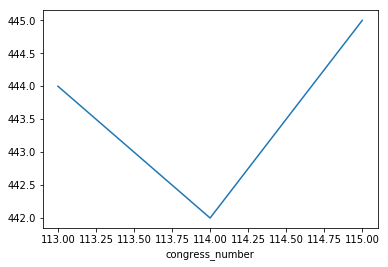

In [466]:
congress_sizes = all_members.groupby('congress_number').size()
congress_sizes.plot()
plt.show()

I expected the number to be constant. Moreover, I would also expect the number to be uneven, so ties cannot occure.

In [470]:
times_in_congress = groups.size().sort_values()

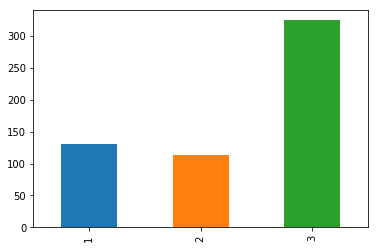

In [471]:
result = times_in_congress.groupby(times_in_congress).size()
result.plot('bar')
plt.show()

States represented in the house of representatives.

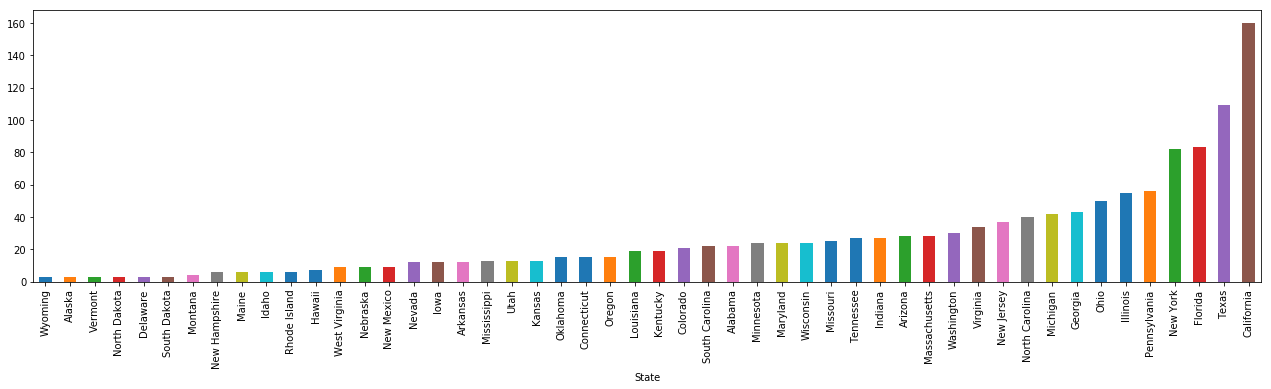

In [472]:
state_sizes = all_members.groupby('State').size().sort_values()
state_sizes.plot('bar', figsize=(22, 5))
plt.show()

The composition of the house of representatives over time

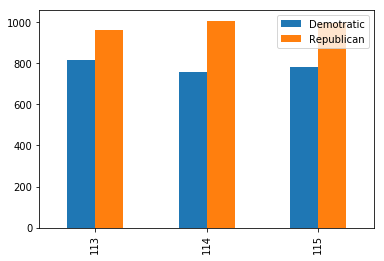

In [473]:
grouped_parties = all_members.groupby(['Party', 'congress_number'])
parties = pd.DataFrame({
    'Demotratic': [group.size for key, group in grouped_parties if key[0] == 'Democratic'],
    'Republican': [group.size for key, group in grouped_parties if key[0] == 'Republican']
}, index = sorted(list(set([key[1] for key, _ in grouped_parties]))))
parties.plot(kind='bar')
plt.show()

# Part B: Download the wikipedia pages of politicians

In [474]:
import json
import requests
import os
from datetime import datetime

endpoint = 'https://en.wikipedia.org/w/api.php'

def getWiki(query, start, end):
    action = 'action=query'
    title = 'titles=%s' % query
    content = 'prop=revisions&rvprop=timestamp|content'
    dataformat = 'format=json'
    
    rvdir = 'rvdir=older'
    start = 'rvstart=' + start.isoformat() + 'Z'
    end = 'rvend=' + end.isoformat() + 'Z'
    limit = 'rvlimit=1'
    rvslots = 'rvslots=main'
    
    url = endpoint + '?' + '&'.join([
        action, title, content, dataformat,
        rvdir, start, end, limit
    ])
    
    return requests.get(url)

In [475]:
# Test request
response = getWiki('John_Dingell', datetime(2015, 1, 3), datetime(2013, 1, 3))

In [476]:
def savePage(response, path):
    content = list(response.json()['query']['pages'].values())[0]
    filename = content['title']
    path = os.path.join('data', path)

    if not os.path.isdir(path):
        os.makedirs(path)
        
    with open(os.path.join(path, filename), 'w') as f:
        json.dump(content, f)

In [ ]:
# for names in [x.groupby(['WikiPageName', 'congress_number']) for x in df]:
def getAllWikisForCongress(data, start, end):
    for key, group in data.groupby(['WikiPageName', 'congress_number']):
        name = key[0]
        congress = str(key[1])
        savePage(getWiki(name, start, end), congress)

In [ ]:
# NOTE: Only run this to refresh the data from wikipedia!
getAllWikisForCongress(df[0], datetime(2015, 1, 3), datetime(2013, 1, 3))
getAllWikisForCongress(df[1], datetime(2017, 1, 3), datetime(2015, 1, 3))
getAllWikisForCongress(df[2], datetime(2019, 1, 3), datetime(2017, 1, 3))

# Part C: Building the networks

In [ ]:
import networkx as nx

In [ ]:
members_names = df[0].groupby('WikiPageName')['WikiPageName'].groups

In [ ]:
def getFileContent(name, congress_number):
    with open(os.path.join('data', str(congress_number), str(name)), 'r') as f:
        content = json.load(f)
        
    return content['revisions'][0]['*']

In [ ]:
def findLinks(content):
    for link in re.findall(r'\[\[(.*?)\]\]', content):
        yield re.sub('\|.*', '', link)

In [ ]:
def isCongressMember(name, members_names):
    name = re.sub(r'\ ', '_', name)
    return name in members_names

In [ ]:
def getCongressConnections(name, congress_number):
    content = getFileContent(re.sub('_', ' ', name), congress_number)
    links = findLinks(content)
    for x in links:
        if isCongressMember(x, members_names):
            yield x

In [ ]:
def getEdges():
    for member in members_names:
        for other in getCongressConnections(member, 113):
            yield member, other

In [ ]:
connections = list(getEdges())

G = nx.DiGraph()
G.add_edges_from(connections)

In [ ]:
nx.draw(G, node_size=30, edge_color='#9A9A9A')

In [ ]:
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))

In [ ]:
def plotHistogram(data):
    d_min = min(data)
    d_max = max(data)

    print('d_min:', d_min, 'd_max:', d_max)

    hist, bins = np.histogram(data, bins=max(d_max - d_min, 1))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()

In [ ]:
plotHistogram([x[1] for x in G.out_degree()])

In [ ]:
plotHistogram([x[1] for x in G.in_degree()])

In [ ]:
sorted(G.in_degree(), key=lambda x: x[1], reverse=True)